# Google Analytics Customer Revenue Prediction
## BMGT 438A Google Team
### Lauren Kim, Dennis Morozov, Ekansh Vinaik, Jake Wurman, Anna Xi

This project aims to predict sales and revenue from customers (and eventually, the natural log of sales) based on a Google Analytics dataset. We start below by performing some **exploratory data analysis** (EDA), which includes making a lot of graphs and trying to find where patterns or trends *might* exist in the data.

First, let's start off by loading some important modules. We will mainly use **pandas** for our data analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gc
import sys
import math
import random

from pandas.io.json import json_normalize
from datetime import datetime

Also, let's choose a plot style. FiveThirtyEight has a palette that fits with our slide deck, so let's use that! Additionally, we want to be sure our figure sizes are large enough to be good quality.

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [20, 10]

### Loading the Data

To begin we need to find out which features we'd like to keep. More importantly, the data size we're looking at is about 30 GB (if not more), so we need an efficient way to work with some random sampling of data that is still representative.

This below portion was drafted using known good features (from looking at the data with Excel). Then, we also defined a `load_df` function, which takes care of JSON columns. Additionally, this function loads each `.csv` in chunks to prevent slowdowns and intense memory usage. Finally, notice the `skiprows` parameter in `read_csv`. This parameter only keeps rows with a `0.01` ratio (1% probability), so we'll be using approximately 20000 rows from our data. This is greater than the required 30 or so, and definitely less than 10% of the population (meeting the 10 percent rule).

In [3]:
gc.enable()

features = ['channelGrouping', 'date', 'fullVisitorId', 'visitId',\
       'visitNumber', 'visitStartTime', 'device.browser',\
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',\
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',\
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',\
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',\
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',\
       'trafficSource.adContent', 'trafficSource.campaign',\
       'trafficSource.isTrueDirect', 'trafficSource.keyword',\
       'trafficSource.medium', 'trafficSource.referralPath',\
       'trafficSource.source', 'customDimensions']

def load_df(csv_path):
    # JSON represents the columns that are made of JSON strings
    JSON = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    # p represents the percent of rows to keep
    p = .01
    
    out = pd.DataFrame()
    all_dfs = pd.read_csv(csv_path, sep=',', skiprows=lambda i: i>0 and random.random() > p,
            converters={column: json.loads for column in JSON}, 
            dtype={'fullVisitorId': 'str'},
            chunksize=100000)
    for df in all_dfs:
        df.reset_index(drop=True, inplace=True)
        for column in JSON:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

        keep = df[features]
        del df
        gc.collect()
        out = pd.concat([out, keep], axis=0).reset_index(drop=True)
    return out

Next, let's actually load our data in, and look at how long it takes just to get an idea. We also take a look at the date range we return from the loaded DataFrame (should mostly mirror the original set even though it is such a small subset).

In [4]:
%%time
df = load_df('./train.csv')

print('train date:', min(df['date']), 'to', max(df['date']))

train date: 20160801 to 20180430
CPU times: user 37.7 s, sys: 12.9 s, total: 50.6 s
Wall time: 52.4 s


Here, we calculate the transaction revenue as the natural log of itself, and in this way, we get the required *train* datapoint (which we'll use to predict and check against the test).

In [5]:
df['totals.transactionRevenue'].fillna(0, inplace=True)
df['totals.transactionRevenue'] = np.log1p(df['totals.transactionRevenue'].astype(float))
print(df['totals.transactionRevenue'].describe())

count    16973.000000
mean         0.194613
std          1.847337
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         21.177521
Name: totals.transactionRevenue, dtype: float64


Let's make sure our columns are there and look like we expected them to (note types listed).

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16973 entries, 0 to 16972
Data columns (total 30 columns):
channelGrouping               16973 non-null object
date                          16973 non-null int64
fullVisitorId                 16973 non-null object
visitId                       16973 non-null int64
visitNumber                   16973 non-null int64
visitStartTime                16973 non-null int64
device.browser                16973 non-null object
device.deviceCategory         16973 non-null object
device.isMobile               16973 non-null bool
device.operatingSystem        16973 non-null object
geoNetwork.city               16973 non-null object
geoNetwork.continent          16973 non-null object
geoNetwork.country            16973 non-null object
geoNetwork.metro              16973 non-null object
geoNetwork.networkDomain      16973 non-null object
geoNetwork.region             16973 non-null object
geoNetwork.subContinent       16973 non-null object
totals.bounce

Again, to get an idea of how much null data we have, let's count null values per column and see where we'll have the most issues in the future.

In [7]:
null_cnt = df.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])

totals.pageviews                  6
totals.newVisits               4017
totals.bounces                 8347
trafficSource.keyword         10409
trafficSource.referralPath    11290
trafficSource.isTrueDirect    11668
trafficSource.adContent       16287
dtype: int64


In this step, we convert page views, new visits, and bounces to integer values. We also load defaults (1 for views, 0 for visits and bounces) taht seem reasonable. Finally, we load defaults for true direct (**False**, which makes sense because we'd rather have false negatives than positives in this situation).

In [8]:
# fillna object feature
for col in ['trafficSource.keyword',
            'trafficSource.referralPath',
            'trafficSource.adContent']:
    df[col].fillna('unknown', inplace=True)

# fillna numeric feature
df['totals.pageviews'].fillna(1, inplace=True)
df['totals.newVisits'].fillna(0, inplace=True)
df['totals.bounces'].fillna(0, inplace=True)
df['totals.pageviews'] = df['totals.pageviews'].astype(int)
df['totals.newVisits'] = df['totals.newVisits'].astype(int)
df['totals.bounces'] = df['totals.bounces'].astype(int)

# fillna boolean feature
df['trafficSource.isTrueDirect'].fillna(False, inplace=True)

Some columns only have one unique value. Let's drop these so we don't look at useless data.

In [9]:
# drop constant
constants = [col for col in df.columns if df[col].nunique() == 1]

print('drop columns:', constants)
df.drop(constants, axis=1, inplace=True)

drop columns: []


We choose a random visitor ID here (this is actually the visitor that appears most, for a total of **5** times), and look at some sample data. This will help us do more analysis further down the line in case we are interested.

In [10]:
df[df['fullVisitorId'] == '0720311197761340948'].sort_values(by='visitNumber')[
    ['date','visitId','visitNumber','totals.hits','totals.pageviews']].head(20)

,date,visitId,visitNumber,totals.hits,totals.pageviews
3518,20160821,1471806077,4,1,1
14302,20160823,1471954089,5,1,1
11395,20170509,1494396477,116,1,1
16409,20170512,1494573985,119,1,1
11229,20170904,1504590715,170,1,1


In this step, we copy the total revenue and get a feel for the kind of data we're looking at for which revenue is nonnegative and nonzero.

In [11]:
revenue = df[df['totals.transactionRevenue'] > 0].copy()
print(len(revenue))
revenue.head()

187


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions
35,Referral,20160902,4755168908070236728,1472849608,2,1472849608,Chrome,desktop,False,Linux,...,22,17.971891,unknown,(not set),True,unknown,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"
252,Referral,20170613,850560433361022079,1497382779,3,1497382779,Chrome,desktop,False,Chrome OS,...,12,16.587474,unknown,(not set),False,unknown,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"
253,Referral,20170613,2718811501718036973,1497388667,8,1497388667,Chrome,desktop,False,Windows,...,27,18.330428,unknown,(not set),True,unknown,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"
338,Referral,20161110,1338395065492103820,1478794008,2,1478794008,Chrome,desktop,False,Macintosh,...,30,17.909688,unknown,(not set),True,unknown,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"
365,Organic Search,20161112,8534676356103269438,1478979661,1,1478979661,Safari,desktop,False,Macintosh,...,36,18.756724,unknown,(not set),False,unknown,(none),unknown,(direct),"[{'index': '4', 'value': 'North America'}]"


Thsi is a function that plots a column from all data points vs. revenue data only. Basically, we see the ratio of either all data points or data points with revenue within each grouping.

In [12]:
def plotCategoryRateBar(a, b, colName, topN=np.nan):
    if topN == topN: # isNotNan
        vals = b[colName].value_counts()[:topN]
        subA = a.loc[a[colName].isin(vals.index.values), colName]
        temp = pd.DataFrame({'All':subA.value_counts() / len(a), 'Revenue':vals / len(b)})
    else:
        temp = pd.DataFrame({'All':a[colName].value_counts() / len(a), 'Revenue':b[colName].value_counts() / len(b)})
    temp.sort_values('Revenue').plot.barh(color=['orange', 'green'])
    plt.xlabel('Ratio of Total')
    plt.ylabel('Grouping')

## customDimensions

unique customDimensions count: 6


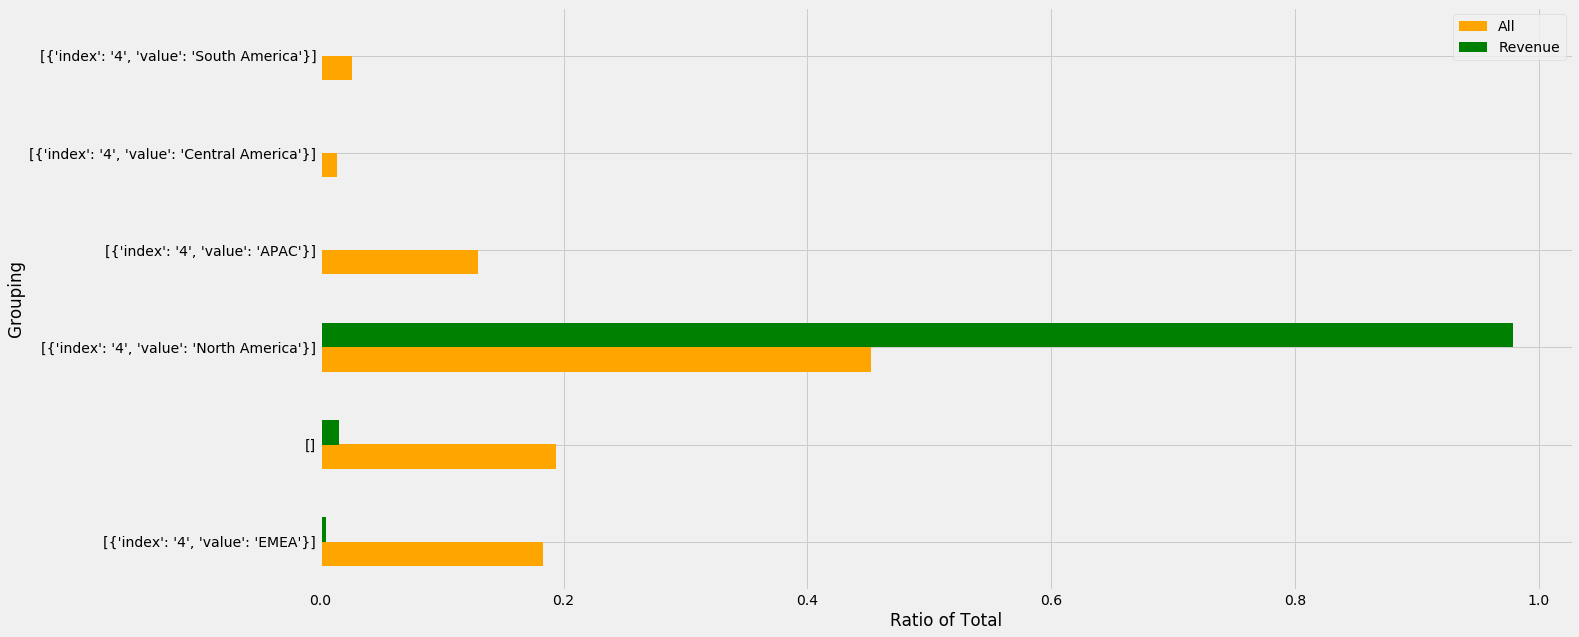

In [13]:
print('unique customDimensions count:', df['customDimensions'].nunique())
plotCategoryRateBar(df, revenue, 'customDimensions')

## date

In [14]:
format_str = '%Y%m%d'
df['formatted_date'] = df['date'].apply(lambda x: datetime.strptime(str(x), format_str))
df['_year'] = df['formatted_date'].apply(lambda x:x.year)
df['_month'] = df['formatted_date'].apply(lambda x:x.month)
df['_quarterMonth'] = df['formatted_date'].apply(lambda x:x.day//8)
df['_day'] = df['formatted_date'].apply(lambda x:x.day)
df['_weekday'] = df['formatted_date'].apply(lambda x:x.weekday())

df.drop(['date','formatted_date'], axis=1, inplace=True)

## channelGrouping
* The channel via which the user came to the Store.

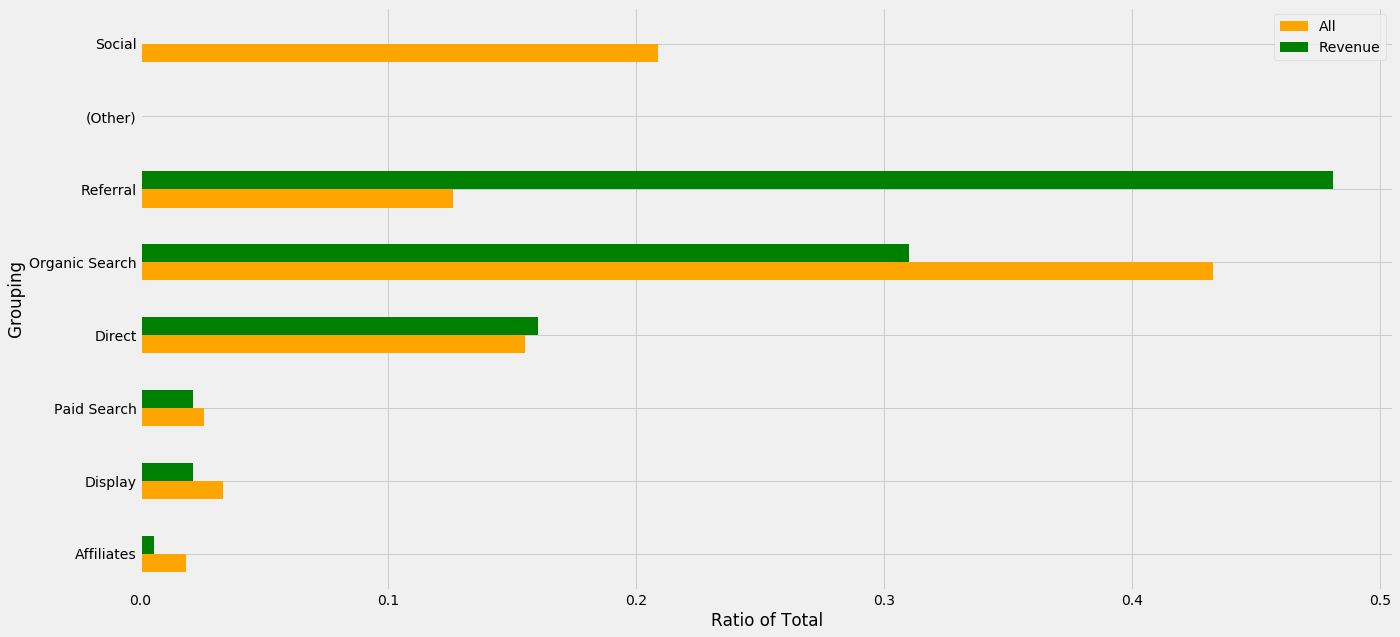

In [15]:
plotCategoryRateBar(df, revenue, 'channelGrouping')

## fullVisitorId
* A unique identifier for each user of the Google Merchandise Store.

## visitId
* An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user.   
For a completely unique ID, you should use a combination of fullVisitorId and visitId.

## newVisits


In [16]:
print('train all:', len(df))
print('train unique fullVisitorId:', df['fullVisitorId'].nunique())
print('train unique visitId:', df['visitId'].nunique())

train all: 16973
train unique fullVisitorId: 16829
train unique visitId: 16971


In [17]:
print(df['visitNumber'].value_counts()[:5])
print('-' * 30)
print(df['totals.newVisits'].value_counts())
print('-' * 30)
print(df['totals.bounces'].value_counts())

1    12956
2     1803
3      751
4      374
5      239
Name: visitNumber, dtype: int64
------------------------------
1    12956
0     4017
Name: totals.newVisits, dtype: int64
------------------------------
1    8626
0    8347
Name: totals.bounces, dtype: int64


In [18]:
df['_visitStartHour'] = df['visitStartTime'].apply(
    lambda x: str(datetime.fromtimestamp(x).hour))

## device

unique browser count: 22


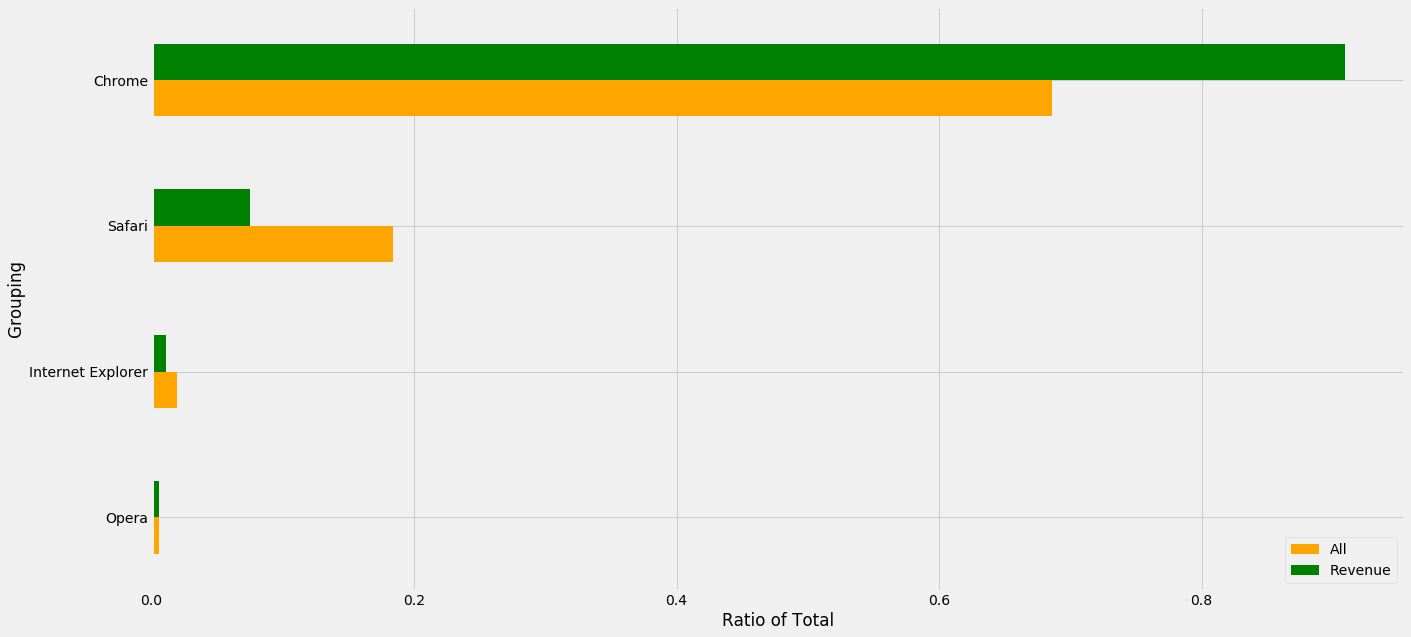

In [19]:
print('unique browser count:', df['device.browser'].nunique())
plotCategoryRateBar(df, revenue, 'device.browser', 10)

In [20]:
pd.crosstab(df['device.deviceCategory'], df['device.isMobile'], margins=False)

df['isMobile'] = True
df.loc[df['device.deviceCategory'] == 'desktop', 'isMobile'] = False

unique operatingSystem count: 12


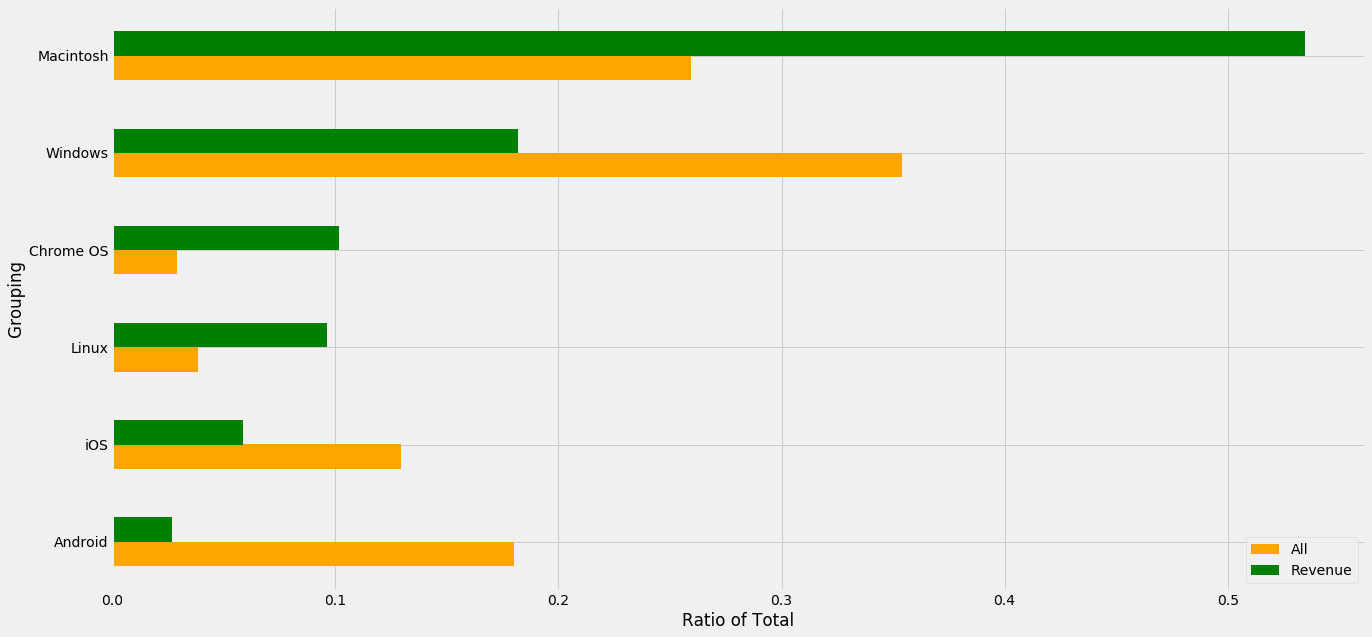

In [21]:
print('unique operatingSystem count:', df['device.operatingSystem'].nunique())
plotCategoryRateBar(df, revenue, 'device.operatingSystem', 10)

## geoNetwork

unique geoNetwork.city count: 386


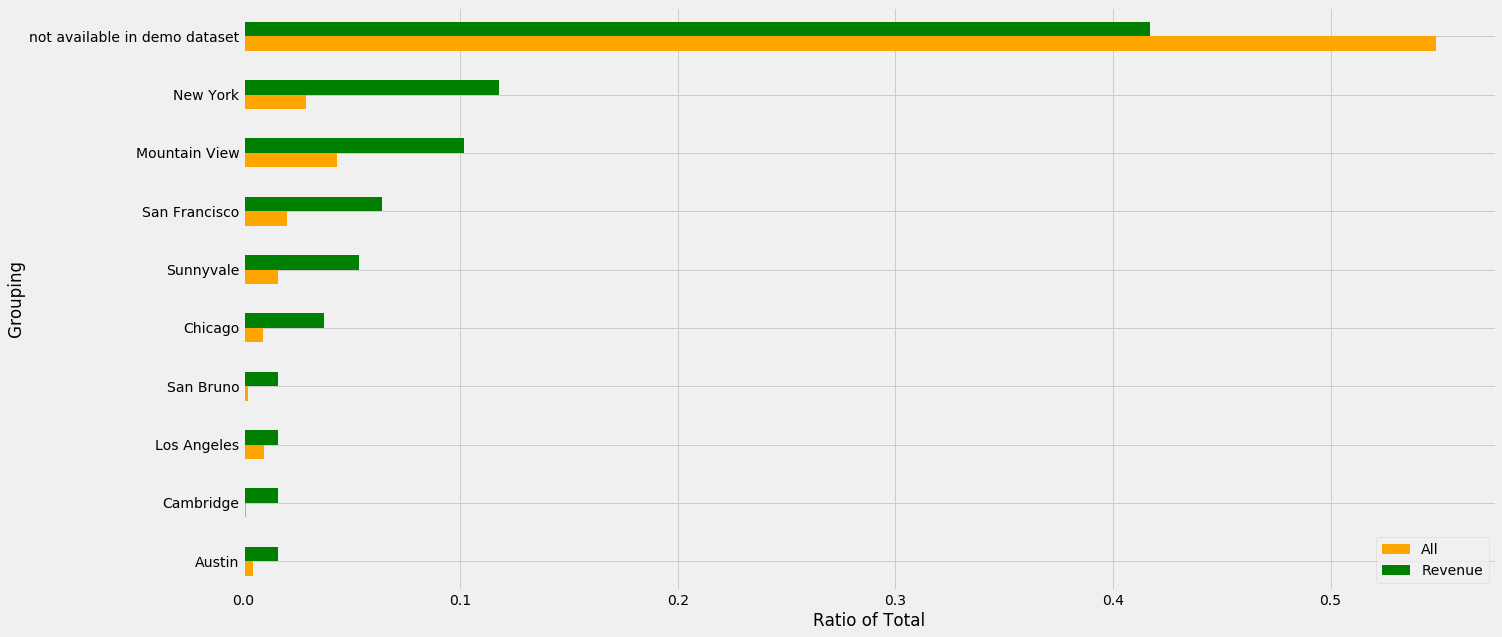

In [22]:
print('unique geoNetwork.city count:', df['geoNetwork.city'].nunique())
plotCategoryRateBar(df, revenue, 'geoNetwork.city', 10)

unique geoNetwork.region count: 262


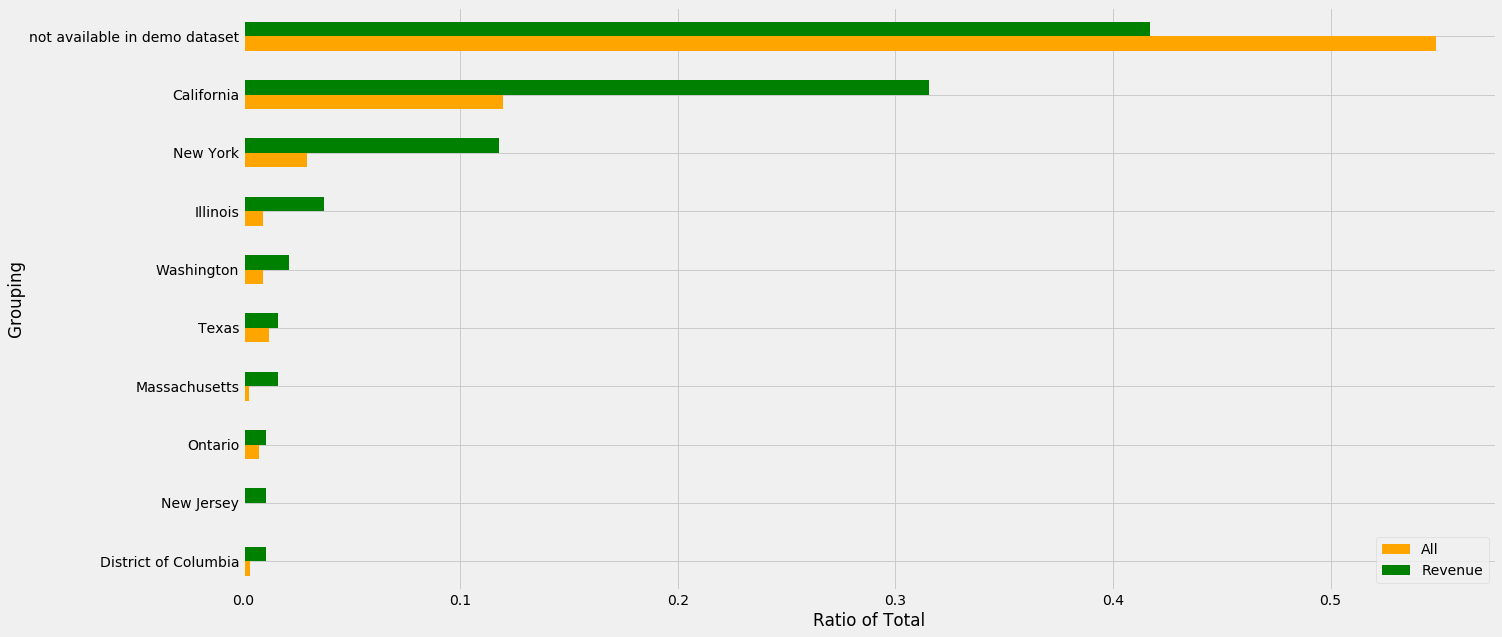

In [23]:
print('unique geoNetwork.region count:', df['geoNetwork.region'].nunique())
plotCategoryRateBar(df, revenue, 'geoNetwork.region', 10)

unique geoNetwork.subContinent count: 21


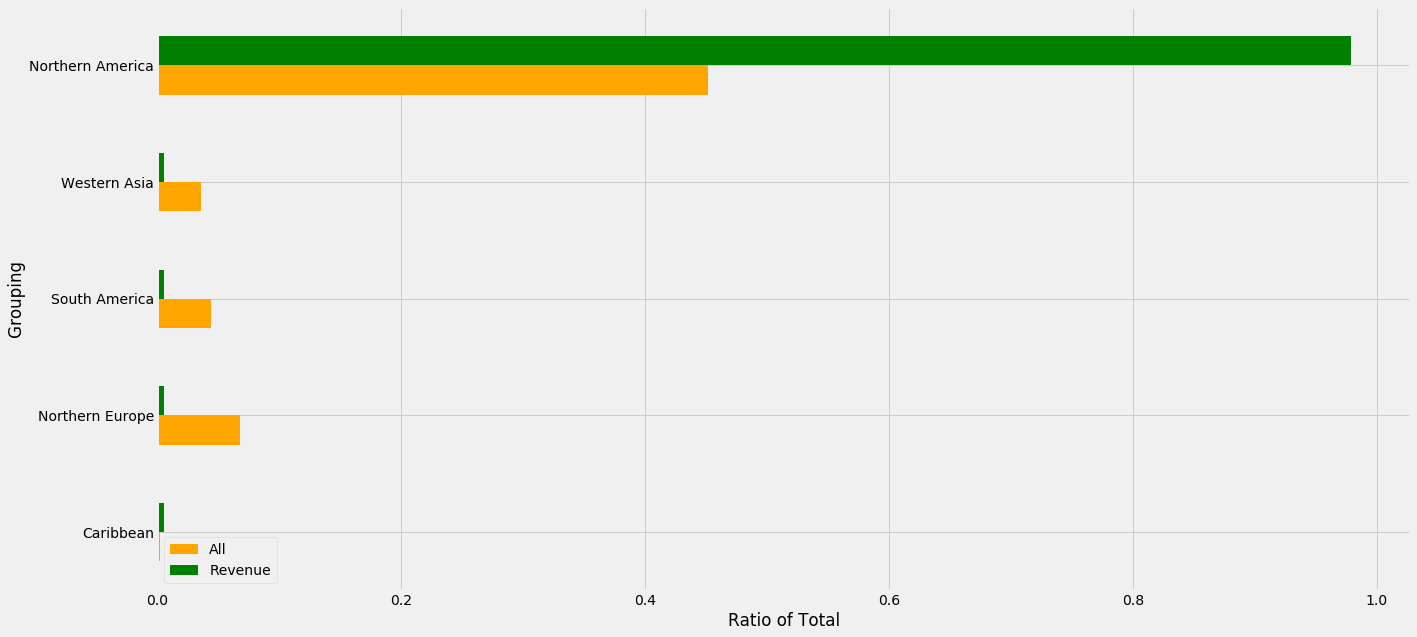

In [24]:
print('unique geoNetwork.subContinent count:', df['geoNetwork.subContinent'].nunique())
plotCategoryRateBar(df, revenue, 'geoNetwork.subContinent', 10)

unique geoNetwork.continent count: 6


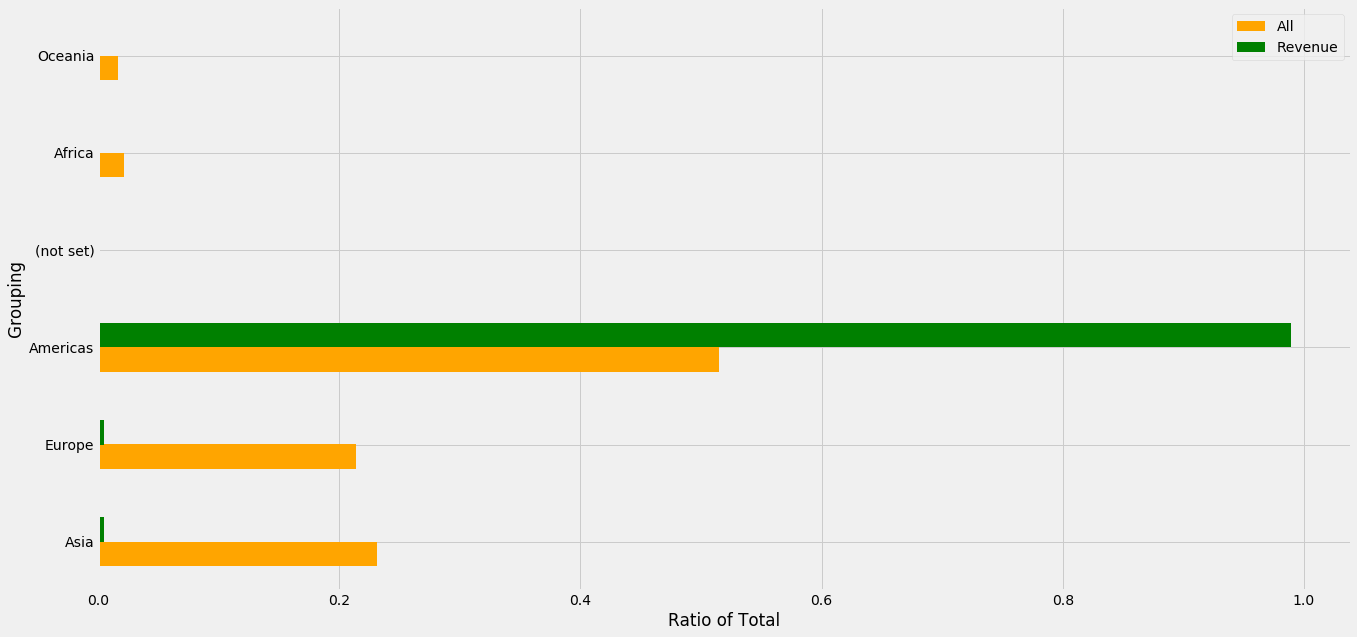

In [25]:
print('unique geoNetwork.continent count:', df['geoNetwork.continent'].nunique())
plotCategoryRateBar(df, revenue, 'geoNetwork.continent')

unique geoNetwork.metro count: 68


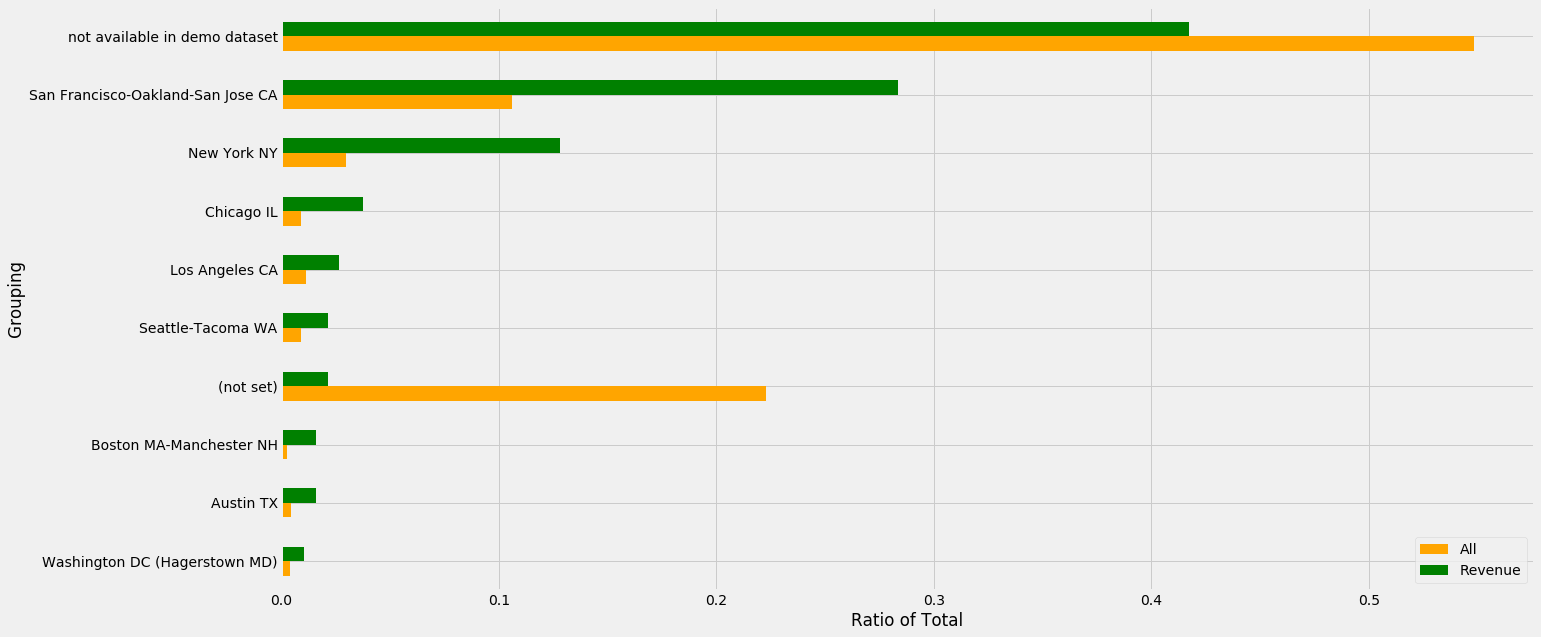

In [26]:
print('unique geoNetwork.metro count:', df['geoNetwork.metro'].nunique())
plotCategoryRateBar(df, revenue, 'geoNetwork.metro', 10)

unique geoNetwork.networkDomain count: 2368


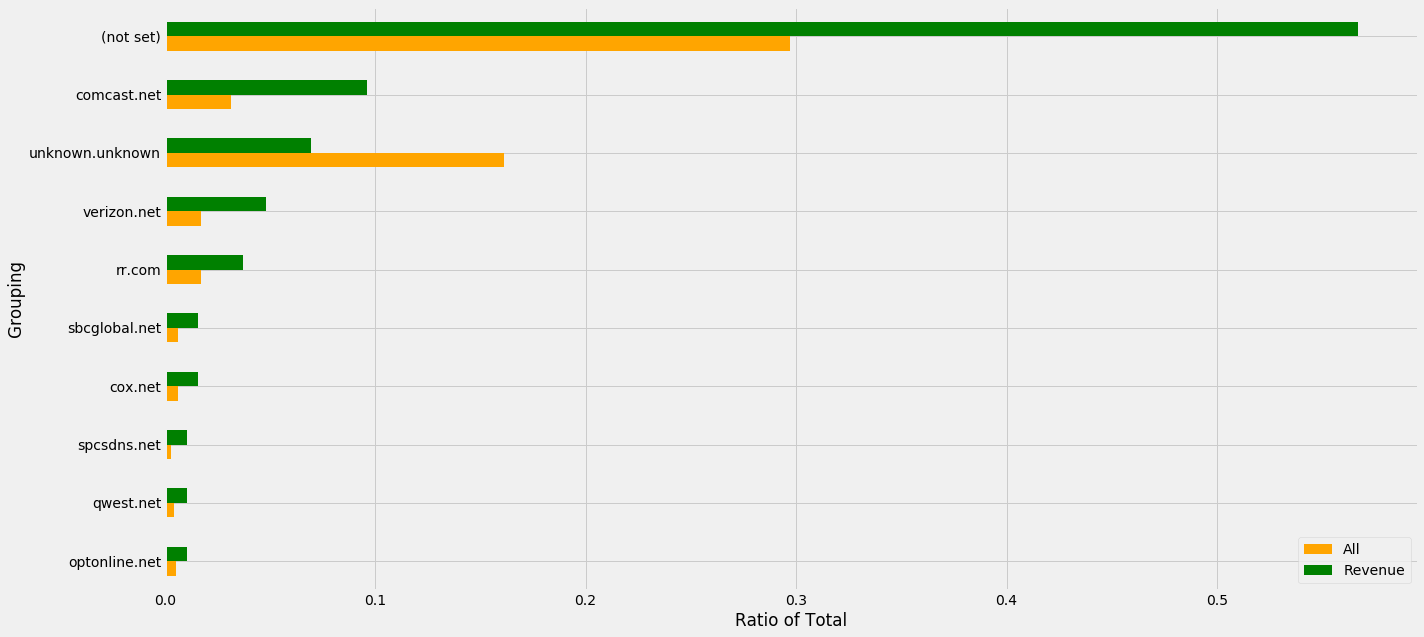

In [27]:
print('unique geoNetwork.networkDomain count:', df['geoNetwork.networkDomain'].nunique())
plotCategoryRateBar(df, revenue, 'geoNetwork.networkDomain', 10)

## totals

In [28]:
print(df['totals.hits'].value_counts()[:10])

df['totals.hits'] = df['totals.hits'].astype(int)

1     8562
2     2347
3     1295
4      829
5      643
6      461
7      383
8      300
9      246
10     221
Name: totals.hits, dtype: int64


In [29]:
print(df['totals.pageviews'].value_counts()[:10])

df['totals.pageviews'] = df['totals.pageviews'].astype(int)

1     8672
2     2468
3     1382
4      903
5      659
6      468
7      371
8      311
9      237
10     214
Name: totals.pageviews, dtype: int64


## trafficSource

False    11668
True      5305
Name: trafficSource.isTrueDirect, dtype: int64


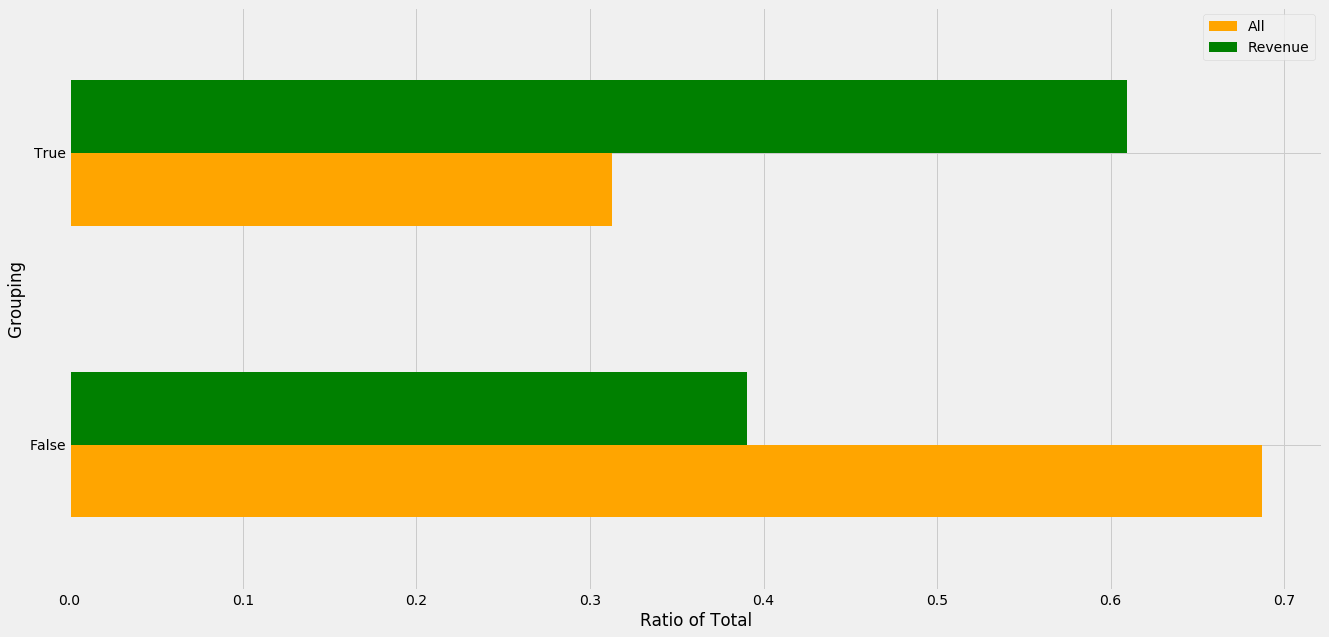

In [30]:
print(df['trafficSource.isTrueDirect'].value_counts())
plotCategoryRateBar(df, revenue, 'trafficSource.isTrueDirect')

unique trafficSource.source count: 81


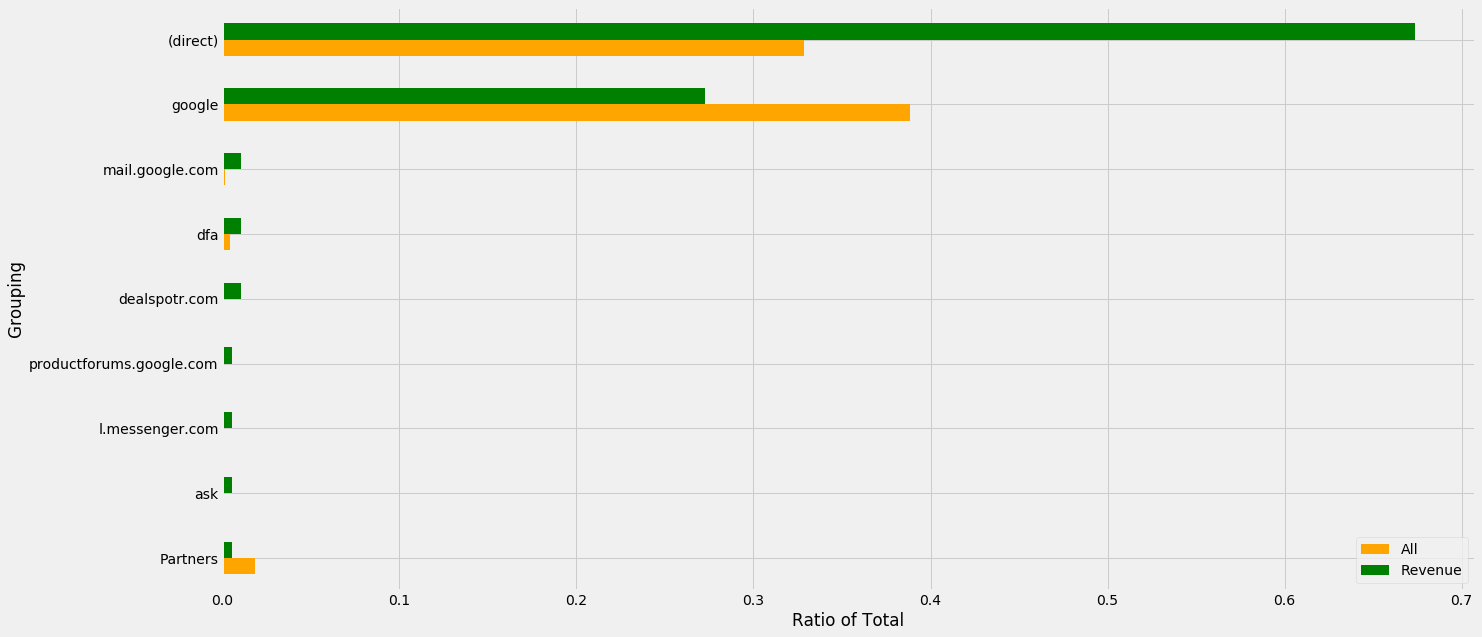

In [31]:
print('unique trafficSource.source count:', df['trafficSource.source'].nunique())
plotCategoryRateBar(df, revenue, 'trafficSource.source', 10)

df['_sourceGpmall'] = (df['trafficSource.source'] == 'mall.googleplex.com').astype(np.uint8)